In [1]:
import praw
import os
import dotenv

dotenv.load_dotenv()

reddit = praw.Reddit(
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET"),
    username=os.getenv("USERNAME"),
    password=os.getenv("PASSWORD"),
    user_agent="music_trends_app:v1.0 (by u/YOUR_USERNAME)"
)

In [2]:
print(reddit.user.me())


Emotional_Kiwi_5256


In [9]:
subreddit_name = "politics"   # change to what you’re studying
subreddit = reddit.subreddit(subreddit_name)

submissions = list(subreddit.hot(limit=20))
print(len(submissions), "posts fetched")

20 posts fetched


In [10]:
submission = submissions[0]

submission.comments.replace_more(limit=None)  # pulls full tree
all_comments = submission.comments.list()
print("Total comments (including replies):", len(all_comments))


Total comments (including replies): 30


In [11]:
from collections import deque
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Optional
import pandas as pd
import time

@dataclass
class CascadeNode:
    node_id: str          # "t3_xxx" for submission, "t1_xxx" for comments
    parent_id: Optional[str]  # None for root
    submission_id: str
    depth: int
    author: Optional[str]
    created_utc: float
    score: int
    is_submission: bool

def build_cascade_for_submission(submission) -> List[CascadeNode]:
    """Return list of CascadeNode for one submission."""
    submission_id = f"t3_{submission.id}"

    # Root node = the submission itself
    nodes: List[CascadeNode] = []

    root = CascadeNode(
        node_id=submission_id,
        parent_id=None,
        submission_id=submission_id,
        depth=0,
        author=str(submission.author) if submission.author else None,
        created_utc=float(submission.created_utc),
        score=submission.score,
        is_submission=True,
    )
    nodes.append(root)

    # Expand all comments into a flat list
    submission.comments.replace_more(limit=None)
    comment_queue = deque(submission.comments)

    while comment_queue:
        comment = comment_queue.popleft()

        node = CascadeNode(
            node_id=f"t1_{comment.id}",
            parent_id=comment.parent_id,   # e.g. "t3_xxx" or "t1_yyy"
            submission_id=submission_id,
            depth=comment.depth,           # PRAW gives depth
            author=str(comment.author) if comment.author else None,
            created_utc=float(comment.created_utc),
            score=comment.score,
            is_submission=False,
        )
        nodes.append(node)

        # Add children to queue
        for reply in comment.replies:
            comment_queue.append(reply)

    return nodes


In [12]:
example_cascade = build_cascade_for_submission(submissions[0])
len(example_cascade), example_cascade[:3]

(31,
 [CascadeNode(node_id='t3_1p3wr07', parent_id=None, submission_id='t3_1p3wr07', depth=0, author='optimalg', created_utc=1763827267.0, score=41, is_submission=True),
  CascadeNode(node_id='t1_nq7ntz1', parent_id='t3_1p3wr07', submission_id='t3_1p3wr07', depth=0, author='Georgiachemscientist', created_utc=1763828786.0, score=45, is_submission=False),
  CascadeNode(node_id='t1_nq7jddd', parent_id='t3_1p3wr07', submission_id='t3_1p3wr07', depth=0, author='Georgiachemscientist', created_utc=1763827447.0, score=31, is_submission=False)])

In [13]:
import pandas as pd
from dataclasses import dataclass, asdict
from collections import deque
from typing import Optional, List, Dict, Any

@dataclass
class CascadeNode:
    node_id: str
    parent_id: Optional[str]   # None for submission
    submission_id: str
    depth: int
    author: Optional[str]
    created_utc: float
    score: int
    is_submission: bool

def build_cascade_for_submission(submission) -> List[CascadeNode]:
    submission_id = f"t3_{submission.id}"

    nodes: List[CascadeNode] = []

    # root
    nodes.append(
        CascadeNode(
            node_id=submission_id,
            parent_id=None,
            submission_id=submission_id,
            depth=0,
            author=str(submission.author) if submission.author else None,
            created_utc=float(submission.created_utc),
            score=submission.score,
            is_submission=True,
        )
    )

    # full comment tree
    submission.comments.replace_more(limit=None)
    q = deque(submission.comments)

    while q:
        c = q.popleft()
        nodes.append(
            CascadeNode(
                node_id=f"t1_{c.id}",
                parent_id=c.parent_id,           # "t3_xxx" or "t1_yyy"
                submission_id=submission_id,
                depth=c.depth,
                author=str(c.author) if c.author else None,
                created_utc=float(c.created_utc),
                score=c.score,
                is_submission=False,
            )
        )
        for r in c.replies:
            q.append(r)

    return nodes


In [16]:
subreddit = subreddit_name
print("Fetched", len(submissions), "posts")

all_nodes: List[Dict[str, Any]] = []
for i, submission in enumerate(submissions, start=1):
    print(f"{i}. {submission.title[:80]}  (comments={submission.num_comments})")
    try:
        cascade_nodes = build_cascade_for_submission(submission)
        all_nodes.extend(asdict(n) for n in cascade_nodes)
    except Exception as e:
        print("   Skipping due to error:", e)

all_nodes_df = pd.DataFrame(all_nodes)
all_nodes_df.head()


Fetched 5 posts
1. What’s something you didn’t realize was optional in life until you saw someone s  (comments=8416)
2. Twitter just started revealing country of origin exposing a number of political   (comments=1250)
3. What's a company that didn't succomb to 'enshittification' ?  (comments=6786)
   Skipping due to error: received 429 HTTP response
4. The House has just voted in a veto-proof majority for Ro Khanna/Thommas Massie’s  (comments=831)
   Skipping due to error: received 429 HTTP response
5. Women of reddit: Whats the girl code you won't break ever?  (comments=2961)
   Skipping due to error: received 429 HTTP response


,node_id,parent_id,submission_id,depth,author,created_utc,score,is_submission
0,t3_1ozsavp,None,t3_1ozsavp,0,Objective-Treat2245,1.763413e+09,16073,True
1,t1_npf1lvl,t3_1ozsavp,t3_1ozsavp,0,shesus_x,1.763429e+09,3143,False
2,t1_npfcm8k,t3_1ozsavp,t3_1ozsavp,0,RestDayDenier,1.763433e+09,4928,False
3,t1_npfehfi,t3_1ozsavp,t3_1ozsavp,0,PrestigiousOne1786,1.763433e+09,8909,False
4,t1_npf3bg3,t3_1ozsavp,t3_1ozsavp,0,bambootaro,1.763429e+09,12488,False


In [18]:
import networkx as nx

def build_graph_from_nodes(nodes_df, submission_id):
    """Builds a DiGraph for ONE cascade from your DataFrame."""

    sub_df = nodes_df[nodes_df["submission_id"] == submission_id]

    G = nx.DiGraph()

    # Add nodes
    for _, row in sub_df.iterrows():
        G.add_node(
            row["node_id"],
            author=row["author"],
            depth=row["depth"],
            score=row["score"],
            is_submission=row["is_submission"]
        )

    # Add edges
    for _, row in sub_df.iterrows():
        if pd.notna(row["parent_id"]):
            G.add_edge(row["parent_id"], row["node_id"])

    return G


In [19]:
def get_early_adopters(nodes_df, submission_id, k=10):
    """Returns first k DISTINCT commenters by timestamp."""
    sub_df = nodes_df[
        (nodes_df["submission_id"] == submission_id) &
        (~nodes_df["is_submission"])
    ].sort_values("created_utc")

    early = (
        sub_df.dropna(subset=["author"])
              .drop_duplicates(subset=["author"])
              .head(k)["author"]
              .tolist()
    )
    return early


In [20]:
example_sub = all_nodes_df["submission_id"].iloc[0]
early = get_early_adopters(all_nodes_df, example_sub, k=10)
early


['BluebirdNo2429',
 'TraditionalTackle1',
 'JellyBellyInjun',
 'CrimsonOOmpa',
 'TJfreshman20',
 'DowntownCrow6427',
 'pastajewelry',
 'tastydrink1',
 'Ok_Swimming4427',
 'JoeMorgue']

In [26]:
import matplotlib.pyplot as plt

def plot_cascade(G, early_adopters):
    """Hierarchical cascade visualization."""

    plt.figure(figsize=(12, 10))

    # Try to use Graphviz for cleaner tree layout
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    except:
        pos = nx.spring_layout(G, seed=42)

    node_colors = []
    node_sizes = []

    for n, data in G.nodes(data=True):
        if data["is_submission"]:
            node_colors.append("red")
            node_sizes.append(400)
        elif data["author"] in early_adopters:
            node_colors.append("orange")
            node_sizes.append(200)
        else:
            node_colors.append("skyblue")
            node_sizes.append(80)

    nx.draw(
        G,
        pos,
        node_color=node_colors,
        node_size=node_sizes,
        arrows=False,
        with_labels=False,
        alpha=0.8
    )

    plt.title("Cascade Graph (red=submission, orange=early adopters)")
    plt.axis("off")
    plt.show()
    
def trim_nodes(nodes_df, submission_id, max_nodes=300):
    sub = nodes_df[nodes_df["submission_id"] == submission_id] \
            .sort_values("created_utc")

    # Keep root
    root = sub[sub["is_submission"]]

    # Keep earliest comments
    comments = sub[~sub["is_submission"]].head(max_nodes)

    trimmed = pd.concat([root, comments], ignore_index=True)
    return trimmed


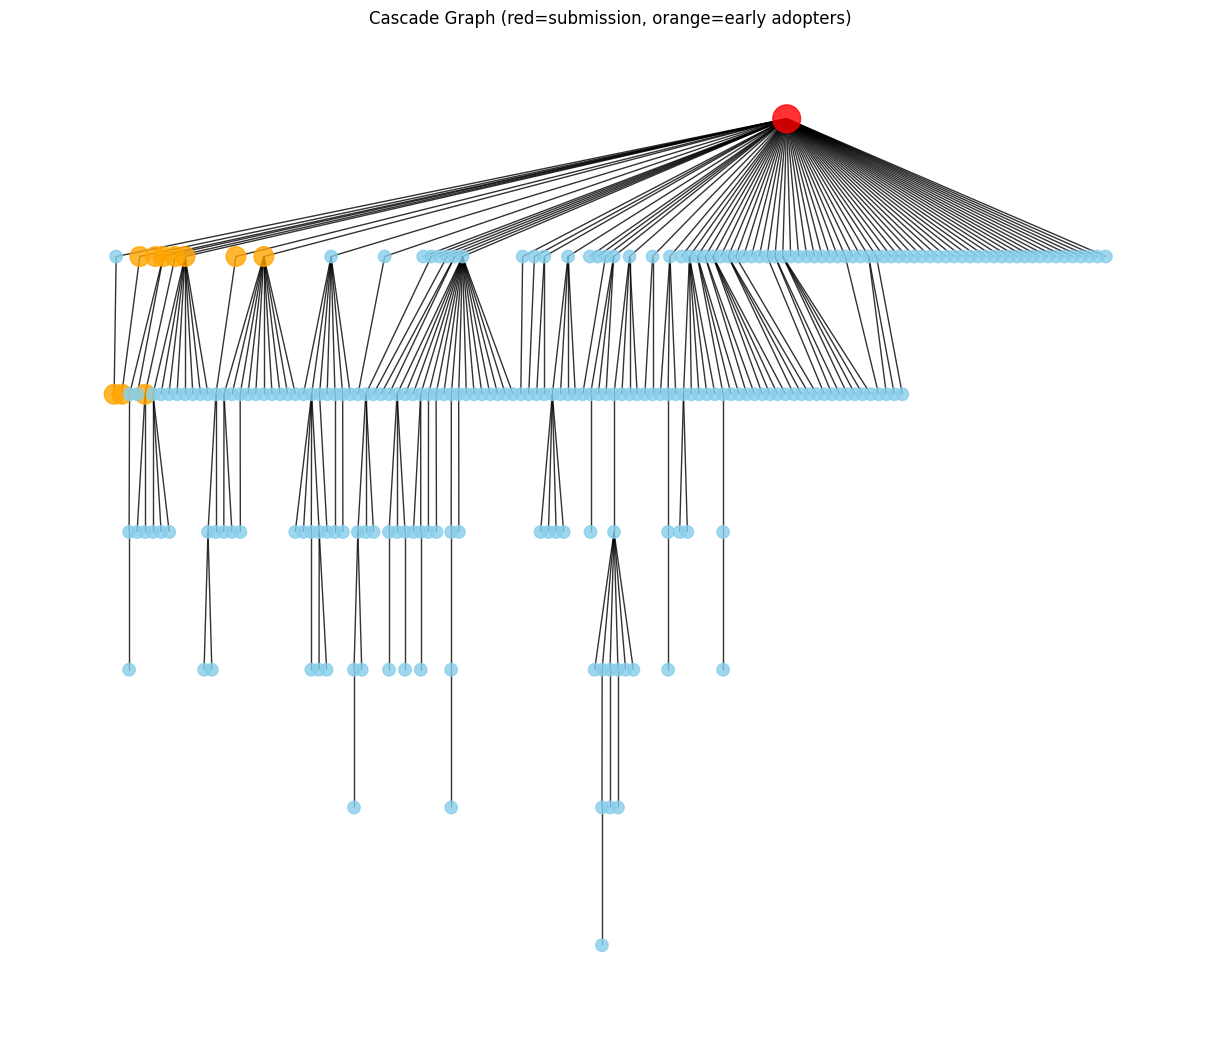

In [27]:
trimmed = trim_nodes(all_nodes_df, example_sub, max_nodes=250)
G = build_graph_from_nodes(trimmed, example_sub)
plot_cascade(G, early)